# COMP41680 - Assignment 1
##### Adam Judge - 16343971

## Task 1: Identify one or more suitable web APIs
###### Api Chosen:
A single API chosen for this assignment was the COVID-19 API - https://covid19api.com/


In [38]:
import os
import numpy as np
import urllib.request
import json
import pandas as pd 
pd.set_option("display.max_rows", None)
import requests
import time
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta, date

# Task 1: Collect data from chosen API
###### Collect Data:
The following functions are used in the creation of files, Collection of data

In [2]:
def Json2file(Folder, FileName, Data):
    print(f"Writing JSON data to {Folder}/{FileName}")
    with open(Folder+"/"+FileName, "w") as File:
        json.dump(Data, File)
    File.close()

def makeDir(Folder):
    if not os.path.exists(Folder):
        os.mkdir(Folder)
    else:
        print(f"Folder {Folder} already exists!")


### Raw COVID-19 data will be extracted for all countries in the European Union and written to .json files
The API in use occasionally returns 503 errors for periods of minutes to hours at a time, as such this may not collect all required data

In [3]:
# All countries in EU
# Note that Czechia is referred to as Czech-Republic as this is the country name contained in the API's json files
countries = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech-Republic", "Denmark", "Estonia", "Finland",
             "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg",
             "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"]
# 100ks of person per country based on National Estimates
pop=           {"Austria": 8857960,
               "Belgium": 11449656,
               "Bulgaria": 7000039,
               "Croatia": 4105493,
               "Cyprus": 864200,
               "Czech-Republic": 10627794,
               "Denmark": 5837213,
               "Estonia": 1328976,
               "Finland": 5522015,
               "France": 67076000,
               "Germany": 83122889,
               "Greece": 10768193,
               "Hungary": 9771000,
               "Ireland": 4921500,
               "Italy": 60390560,
               "Latvia": 1921300,
               "Lithuania": 2794090,
               "Luxembourg": 626108,
               "Malta": 514564,
               "Netherlands": 17417600,
               "Poland": 38433600,
               "Portugal": 10276617,
               "Romania": 19523621,
               "Slovakia": 5445087,
               "Slovenia": 2070050, 
               "Spain": 46733038,
               "Sweden": 10319601}

In [4]:
FileNames=[]
ErrCnt=0
# Make directory to store raw json data from API
makeDir("Raw_Data")
RawFolder="./Raw_Data"
# Iterate through countries and make request for data from API
# No key required
for i, c in enumerate(countries):
    URL=f"http://api.covid19api.com/total/dayone/country/{c}"
    # Only requires URL for specific API
    response=requests.get(URL)
    # If response status is okay
    if response.status_code == 200:
        print(f"Successfully obtained data for {c}")
        # Write response to json file
        Json2file("./Raw_Data",f"{c}_rawdata.json", response.json())
        # Append filename to list
        FileNames.append(f"{c}_rawdata.json")
    # Bad response code, print details and increment error count
    else:
        print(f"Error for country {c}, {response.status_code}")
        ErrCnt+=1
        FileNames.append(f"{c}_rawdata.json")
        
    # Delay so as to not request too much in short period of time
    time.sleep(1)
# Print number of errors found
print(f"Number of errors: {ErrCnt}")

Folder Raw_Data already exists!
Error for country Austria, 503
Error for country Belgium, 503
Error for country Bulgaria, 503
Error for country Croatia, 503
Error for country Cyprus, 503
Error for country Czech-Republic, 503
Error for country Denmark, 503
Error for country Estonia, 503
Error for country Finland, 503
Error for country France, 503
Error for country Germany, 503
Error for country Greece, 503
Error for country Hungary, 503
Error for country Ireland, 503
Error for country Italy, 503
Error for country Latvia, 503
Error for country Lithuania, 503
Error for country Luxembourg, 503
Error for country Malta, 503
Error for country Netherlands, 503
Error for country Poland, 503
Error for country Portugal, 503
Error for country Romania, 503
Error for country Slovakia, 503
Error for country Slovenia, 503
Error for country Spain, 503
Error for country Sweden, 503
Number of errors: 27


## Data Preparation and Modification Functions
##### Parsing Raw Data:
The raw data for each country starts from the first known covid case reported in said country, and the following columns of data are contained in the raw data in order:
* Country
* CountryCode
* Province
* City
* CityCode
* Lat
* Lon
* Confirmed
* Deaths
* Recovered
* Active
* Date

It can be noted that the active and recovered numbers are poor as these numbers are simply not tracked to any reasonable degree of accuracy in the majority of countries.
The Lat and Lon, or latitude and longitude may be discarded, as well as the CountryCode, Province, City, CityCode, Recovered, and Active. These are not of interest in the comparison between european countries.

Additional columns are desired for this such as New Cases, New Deaths, as well as data per 100k of population. These will allow for the comparison between countries with varied population sizes, such as Malta and Germany. These columns may be inferred from the cumulative deaths and confirmed columns as well as the date.

Any missing data such as missing dates will be added to the dataset, with new cases and new deaths being taken as 0 for these periods. The cumulative values will take the previous dates values.

In [24]:
# This function extracts the daily new cases/deaths from the total cumulative cases
def getDailyCasesDeaths(df):
    # List of confirmed cases and deaths to list
    TotalCases=df["Confirmed"].tolist()
    TotalDeaths=df["Deaths"].tolist()
    DailyCases=[]
    DailyDeaths=[]
    negCaseOcc=0
    negDeathOcc=0
    # Iterate through the total confirmed cases and deaths
    for i, (TC, TD) in enumerate(zip(TotalCases, TotalDeaths)):
        #First is the first case(s)
        if i == 0:
            DailyCases.append(TC)
            DailyDeaths.append(TD)
            continue
        
        # Difference between current day and previous days    
        newCases=TC-TotalCases[i-1]
        newDeaths=TD-TotalDeaths[i-1]
        if newCases<0:  
            negCaseOcc+=1
            
        if newDeaths<0:  
            negDeathOcc+=1
            
        DailyCases.append(newCases)
        DailyDeaths.append(newDeaths)
    return DailyCases, DailyDeaths, negCaseOcc, negDeathOcc

# Returns Deaths, Confirmed, Daily Deaths, Daily Confirmed per 100k of population
def perCapita(df, num):
    #Convert population to number of 100ks of population
    num=num/100000
    confirmedPer=df["Confirmed"]/num
    deathsPer=df["Deaths"]/num
    dailyCasesPer=df["New Cases"]/num
    dailyDeathsPer=df["New Deaths"]/num
    return confirmedPer, deathsPer, dailyCasesPer, dailyDeathsPer

# Function to pad data for missing dates from 2020-01-01 to present
def padDates(df):
    # First date will be 2020-01-01
    nextDate=date.fromisoformat("2020-01-01")
    missingCnt=0
    addedCnt=0
    i=0
    # Check all rows based on Date
    while nextDate != datetime.today().date():
        # If the date is present do nothing
        if(nextDate in df["Date"].values):
            pass
        # If date is missing
        else:
            # If first row, cases deaths and new cases all should be zero
            if i==0:
                row2add=[nextDate, df["Country"].iloc[i], 0, 0, 0, 0, 0, 0, 0, 0]
            # If not first row, new cases should be 0, confirmed cases and deaths should be same as prior row
            else:    
                row2add=[nextDate, df["Country"].iloc[i-1], df["Confirmed"].iloc[i-1], df["Confirmed per 100k"].iloc[i-1], 0, 0, df["Deaths"].iloc[i-1],df["Deaths per 100k"].iloc[i-1], 0, 0]
                # Missing date found in middle of data and not at beginning
                if df["Confirmed"].iloc[i-1] != 0:
                    missingCnt+=1
                    
            # Make a dataframe with new row
            new_df=pd.DataFrame([row2add], columns=df.columns.values)
            # Concatenate new row to correct position in dataframe
            df=pd.concat([df[:i], new_df, df[i:]], ignore_index=True)
            addedCnt+=1
            
        i+=1
        nextDate+=timedelta(days=1)
    
    return df, missingCnt, addedCnt

# Reorder columns
def reorderCols(df, Cols):
    dftest=df[Cols]
    return dftest

# Function to remove hr/min/sec/TimeZone from Date entries
def removeTime(df):
    dates=[]
    for d in df["Date"]:
        # If able append yyyymmdd
        try:
            dates.append(d.date())
        # Instance already shortened
        except:
            dates.append(d)
        
    return dates

In [25]:
# Columns to remove from DFs
Columns2Drop=["CountryCode", "Province", "City", "CityCode", "Lat", "Lon", "Recovered", "Active"]
# Column order desired
Cols=["Date", "Country", "Confirmed", "Confirmed per 100k", "New Cases", "New Cases per 100k", "Deaths", "Deaths per 100k", "New Deaths", "New Deaths per 100k"]
negCaseOcc=0
negDeathOcc=0
missingMid=0
missingTot=0
ProcessedDataFolder="./Processed"
FileNamePro=[]
# Make directory to store processed data
makeDir(ProcessedDataFolder)
# Store df's
dflist=[]

# Process data, remove unnecessary columns and append any missing data as appropriate
for country, filename in zip(countries, FileNames):
    # Read raw data
    df=pd.read_json(RawFolder+"/"+filename, orient="records")
    # Drop unnecessary columns
    df=df.drop(Columns2Drop, axis=1)
    # Add new cases and new deaths columns
    df["New Cases"], df["New Deaths"], nc, nd = getDailyCasesDeaths(df)
    #    return confirmedPer, deathsPer, dailyCasesPer, dailyDeathsPer
    df["Confirmed per 100k"], df["Deaths per 100k"], df["New Cases per 100k"], df["New Deaths per 100k"] = perCapita(df,pop[country])
    # Reorder columns in preferred order
    df=reorderCols(df, Cols)
    # Add missing Dates
    df, missingCnt, addedCnt=padDates(df)
    # No interest in hours/mins/secs/timezone
    df["Date"] = removeTime(df)
    # Round values to 2 decimal places
    df=df.round(decimals=2)
    missingMid+=missingCnt
    missingTot+=addedCnt
    negCaseOcc+=nc
    negDeathOcc+=nd
    fileNamePro=f"{country}_processed.json"
    FileNamePro.append(fileNamePro)
    # Write processed data to json file
    df.to_json(ProcessedDataFolder + "/" + fileNamePro)
    dflist.append(df)
    print("Written for " + country)

# Print details 
print(f"Number of missing date entries found after first case: {missingMid}")
print(f"Number of missing date entries found in total: \t{missingTot}")
print(f"Number of days found in total with a drop in cumulative case numbers: {negCaseOcc}")
print(f"Number of days found in total with a drop in cumulative death numbers: {negDeathOcc}")

Written for Austria
Written for Belgium
Written for Bulgaria
Written for Croatia
Written for Cyprus
Written for Czech-Republic
Written for Denmark
Written for Estonia
Written for Finland
Written for France
Written for Germany
Written for Greece
Written for Hungary
Written for Ireland
Written for Italy
Written for Latvia
Written for Lithuania
Written for Luxembourg
Written for Malta
Written for Netherlands
Written for Poland
Written for Portugal
Written for Romania
Written for Slovakia
Written for Slovenia
Written for Spain
Written for Sweden
Number of missing date entries found after first case: 0
Number of missing date entries found in total: 	1411
Number of days found in total with a drop in cumulative case numbers: 21
Number of days found in total with a drop in cumulative death numbers: 52


Processing Data through the usage of the above functions.

### Generate EU averages
A mean dataframe can be generated which is weighted by each countries population. This will allow for a good comparison of Ireland's handling of the pandemic with respect to the European Union Average. This average will include Ireland.
This dataframe is then output to demonstrate the form of which the dataframe takes.

In [37]:
ProcessedDataFolder="./Processed"
length=df.index.size
Confirmed   = [0]*length
ConfirmedPer= [0]*length
NewCases    = [0]*length
NewCasesPer = [0]*length
Deaths      = [0]*length
DeathsPer   = [0]*length
NewDeaths   = [0]*length
NewDeathsPer= [0]*length

EUpop=sum(pop.values())
dfEU = pd.DataFrame(columns=Cols)
country=["European-Union"]*length

for c in countries:
    df=pd.read_json(ProcessedDataFolder + f"/{c.replace(' ', '-')}_processed.json")
    # Ratio of population of C to EU
    pop_cEU=pop[c]/EUpop
    for i in range(length):
        Confirmed[i]   +=df["Confirmed"].iloc[i]*pop_cEU
        ConfirmedPer[i]+=df["Confirmed per 100k"].iloc[i]*pop_cEU
        NewCases[i]    +=df["New Cases"].iloc[i]*pop_cEU
        NewCasesPer[i] +=df["New Cases per 100k"].iloc[i]*pop_cEU
        Deaths[i]      +=df["Deaths"].iloc[i]*pop_cEU
        DeathsPer[i]   +=df["Deaths per 100k"].iloc[i]*pop_cEU
        NewDeaths[i]   +=df["New Deaths"].iloc[i]*pop_cEU
        NewDeathsPer[i]+=df["New Deaths per 100k"].iloc[i]*pop_cEU
        
dfEU["Date"]=df["Date"]
dfEU["Country"]=country
dfEU["Confirmed"]=Confirmed
dfEU["Confirmed per 100k"]=ConfirmedPer
dfEU["New Cases"]=NewCases
dfEU["New Cases per 100k"]=NewCasesPer
dfEU["Deaths"]=Deaths
dfEU["Deaths per 100k"]=DeathsPer
dfEU["New Deaths"]=NewDeaths
dfEU["New Deaths per 100k"]=NewDeathsPer
dfEU=dfEU.round(decimals=2)
dfEU.to_json(ProcessedDataFolder + "/European-Union_processed.json")
dflist.append(dfEU)
dfEU

,Date,Country,Confirmed,Confirmed per 100k,New Cases,New Cases per 100k,Deaths,Deaths per 100k,New Deaths,New Deaths per 100k
0,2020-01-01,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-01-02,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-01-03,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2020-01-04,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2020-01-05,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,2020-01-06,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,2020-01-07,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,2020-01-08,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,2020-01-09,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,2020-01-10,European-Union,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Function to plot data of given countries processed dataframe
 This will generate a figure with four subplots with cumulative cases, cumulative deaths, new cases + rolling average, and new deaths + rolling average.

In [27]:
def plotCovidDF(df1):
    Country1=df1["Country"].iloc[0]
    
    df1["Date"]=pd.to_datetime(df1["Date"])
    x=df1["Date"]
    plt.figure(figsize=(16,12));
    tickRange=np.arange(x.iloc[0], x.iloc[-1], timedelta(days=45));
    xlimits=[x.iloc[0], x.iloc[-1]]

    # First Subplot
    plt.subplot(2, 2, 1)
    # Plot
    y=df1["Confirmed per 100k"]
    plt.plot(x ,y, 'k', linewidth="2.5",label=Country1)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Cases per 100k")
    plt.title("Cumulative Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()

    # Second Subplot
    plt.subplot(2,2,2)
    # Plot
    y=df1["Deaths per 100k"]
    plt.plot(x,y,'k', linewidth="2.5", label=Country1)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Deaths per 100k")
    plt.title(f"Cumulative Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()


    # Third Subplot
    plt.subplot(2, 2, 3)
    # Plot
    y=df1["New Cases per 100k"]
    plt.plot(x,y.rolling(7).mean(),"k", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.bar(x, y, 1, color='r', label=Country1, alpha=0.75)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Cases per 100k")
    plt.title("Daily New Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()

    # Fourth Subplot
    plt.subplot(2, 2, 4)
    # Plot
    y=df1["New Deaths per 100k"]
    plt.plot(x, y.rolling(7).mean(), "k", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.bar(x, y, 1, color='r', label=Country1, alpha=0.75)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Deaths per 100k")
    plt.title("Daily New Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(y)*1.1])
    plt.legend()

    plt.tight_layout()

## Function to plot data to compare two different country dataframes
 This will generate a figure with four subplots with cumulative cases, cumulative deaths, new cases + rolling average, and new deaths + rolling average.

In [28]:
def compareCovidDF(df1, df2):
    Country1=df1["Country"].iloc[0]
    Country2=df2["Country"].iloc[0]
    
    #Ensure time fields are in datetime
    df1["Date"]=pd.to_datetime(df1["Date"])
    df2["Date"]=pd.to_datetime(df2["Date"])
    x1=df1["Date"]
    x2=df2["Date"]
    plt.figure(figsize=(16,12));
    tickRange=np.arange(x1.iloc[0], x1.iloc[-1], timedelta(days=45));
    xlimits=[x1.iloc[0], x1.iloc[-1]]

    # First Subplot
    plt.subplot(2, 2, 1)
    # Plot
    y1=df1["Confirmed per 100k"]
    y2=df2["Confirmed per 100k"]
    plt.plot(x1 ,y1, 'g', linewidth="2.5", label=Country1)
    plt.plot(x2 ,y2, 'r', linewidth="2.5", label=Country2)
    plt.fill_between(x1,y1,y2, where=y1>y2, facecolor="green", alpha=0.4)
    plt.fill_between(x1,y1,y2, where=y1<=y2, facecolor="red", alpha=0.4)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Cases per 100k")
    plt.title("Cumulative Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()

    # Second Subplot
    plt.subplot(2,2,2)
    # Plot
    y1=df1["Deaths per 100k"]
    y2=df2["Deaths per 100k"]
    plt.plot(x1,y1,'g', linewidth="2.5", label=Country1)
    plt.plot(x2,y2,'r', linewidth="2.5", label=Country2)
    plt.fill_between(x1,y1,y2, where=y1>y2, facecolor="green", alpha=0.4)
    plt.fill_between(x1,y1,y2, where=y1<=y2, facecolor="red", alpha=0.4)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("Deaths per 100k")
    plt.title(f"Cumulative Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()


    # Third Subplot
    plt.subplot(2, 2, 3)
    # Plot
    y1=df1["New Cases per 100k"]
    y2=df2["New Cases per 100k"]
    plt.plot(x1,y1.rolling(7).mean(),"g", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.plot(x2,y2.rolling(7).mean(),"r", linewidth="2.5", label=f"{Country2} 7-Day avg")
    plt.bar(x1, y1, 1, color='g', label=Country1, alpha=0.5)
    plt.bar(x2, y2, 1, color='r', label=Country2, alpha=0.5)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Cases per 100k")
    plt.title("Daily New Cases per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()

    # Fourth Subplot
    plt.subplot(2, 2, 4)
    # Plot
    y1=df1["New Deaths per 100k"]
    y2=df2["New Deaths per 100k"]
    plt.plot(x1, y1.rolling(7).mean(), "g", linewidth="2.5", label=f"{Country1} 7-Day avg")
    plt.plot(x2,y2.rolling(7).mean(), "r", linewidth="2.5", label=f"{Country2} 7-Day avg")
    plt.bar(x1, y1, 1, color='g', label=Country1, alpha=0.5)
    plt.bar(x2, y2, 1, color='r', label=Country2, alpha=0.5)
    plt.xticks(tickRange);

    # Axis Labels and Title
    plt.xlabel("Date")
    plt.ylabel("New Deaths per 100k")
    plt.title("Daily New Deaths per 100k")
    plt.grid(axis="y")
    plt.setp(plt.xticks()[1], rotation=30, ha='right')

    # Axis Limits
    plt.xlim(xlimits)
    plt.ylim([0, max(max(y1), max(y2))*1.1])
    plt.legend()

    plt.tight_layout()

## Example output for last country alphabetically
This will demonstrate Sweden's COVID-19 Data. We can note that just after the 31st of March 2020 there is a drop in cumulative deaths, this is accurate and represents denotified deaths and can be noticed in official charts.

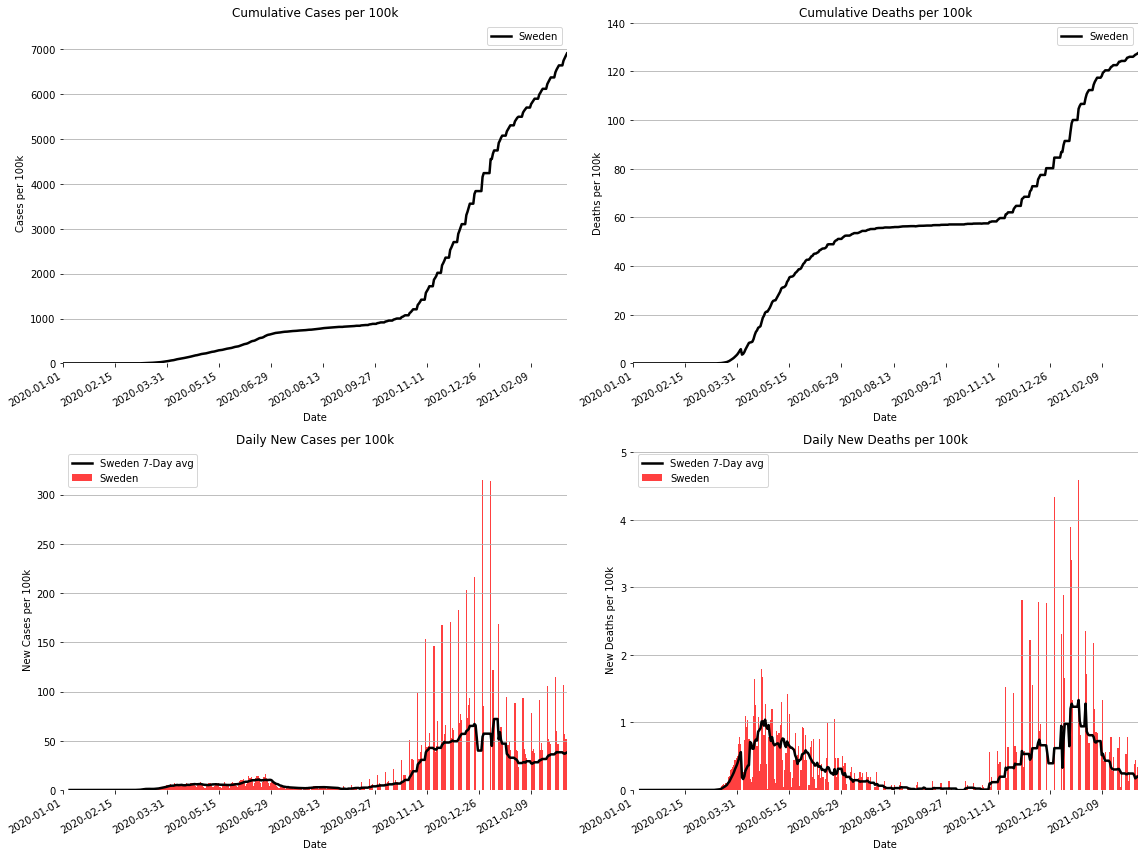

In [29]:
plotCovidDF(df)

### Data Presentation
It is of interest to compare Ireland's COVID-19 Statistics versus that of the european average

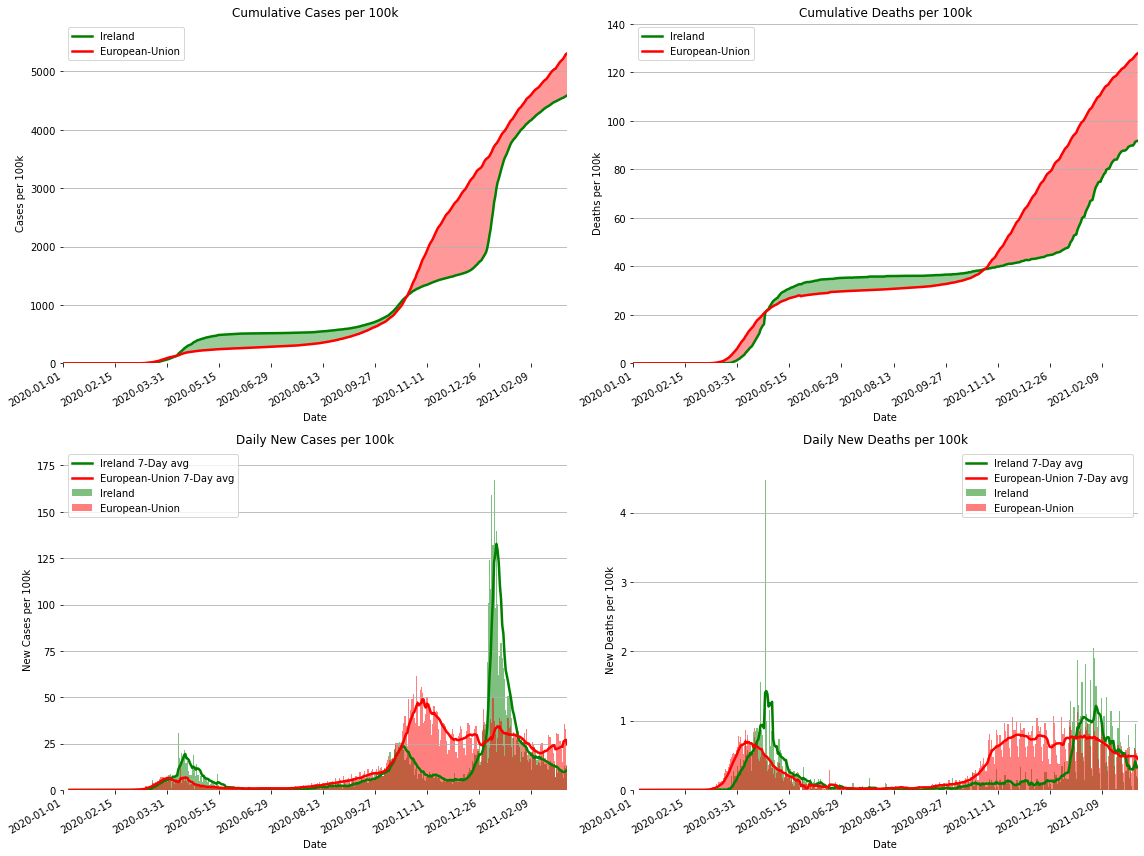

In [30]:
dfIE=pd.read_json(ProcessedDataFolder + f"/Ireland_processed.json")
dfEU=pd.read_json(ProcessedDataFolder + f"/European-Union_processed.json")

compareCovidDF(dfIE, dfEU)

The cumulative cases per 100k shows Ireland performing significantly below the EU average from near the beginning of the pandemic until approximately October of 2020, during this period Ireland observed a higher total number of cases as well as a higher rolling average of daily cases. This trend reversed somewhat in November where the EU experienced a large increase or "second wave" of new cases, which Ireland suppressed moderately effectively. Ireland however experienced a period of time from around Christmas wherein the number of new cases in the country more than doubled the average EU country. This was short lived and Ireland is currently below the average in terms of cumulative cases and Deaths.

Ireland performs similarly to cases in terms of the number of deaths, however there is a clear lag between increases of cases and a following increase in Deaths. This lag is approximately 2 weeks.

The initial wave of cases and deaths started earlier in the EU due to Ireland being on of the Westmost countries in the EU, as well as being an Island.

### Statistics
The above charts give a good visual indication of Ireland's performance, through a bar chart plot against normalised European Union statistics will demonstrate how various statistics compare, such as std in new cases and deaths.

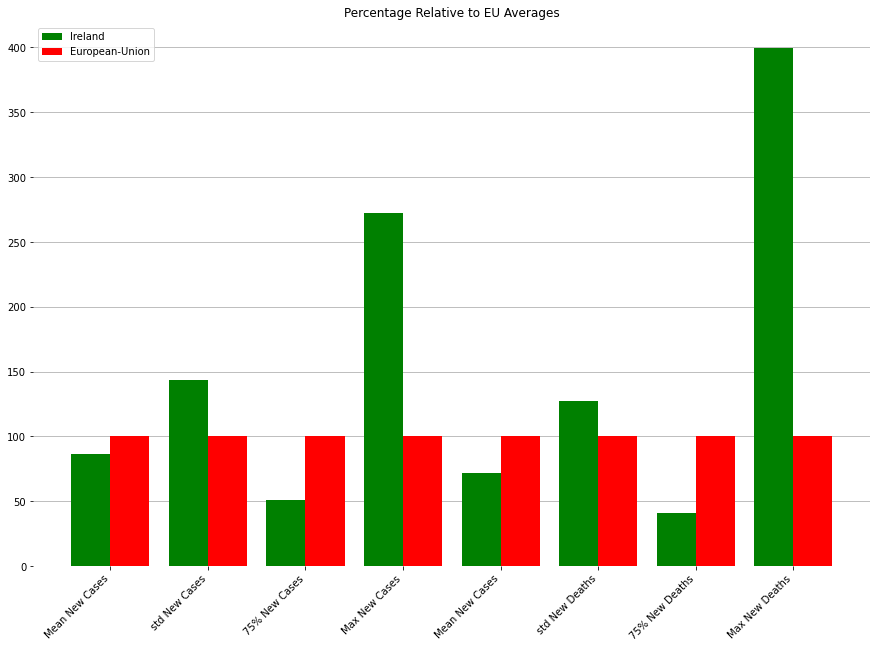

In [31]:
# cases and deaths { mean - std - 75% - max} 
stats=[[0]*8, [0]*8]
stats[0][0:4]=(dfIE["New Cases per 100k"].describe()[["mean", "std", "75%", "max"]])
stats[1][0:4]=(dfEU["New Cases per 100k"].describe()[["mean", "std", "75%", "max"]])
stats[0][4:8]=(dfIE["New Deaths per 100k"].describe()[["mean", "std", "75%", "max"]])
stats[1][4:8]=(dfEU["New Deaths per 100k"].describe()[["mean", "std", "75%", "max"]])

stats=np.array(stats)
# Normalise to european averages
stats=stats/stats[1][:]*100

plt.figure(figsize=(15,10));
axisLabels=["Mean New Cases", "std New Cases", "75% New Cases", "Max New Cases","Mean New Cases", "std New Deaths", "75% New Deaths", "Max New Deaths"]
x = np.arange(0.0, 8.0)
# Width of bars, will leave 20% white space
w=0.4
plt.grid(axis="y")
# Left bars will be Irish Data
plt.bar(x-w/2,stats[0][:],w, log=False, color='g', label="Ireland")
# Rightmost data will be European Data
plt.bar(x+w/2,stats[1][:], w, log=False, color='r', label="European-Union")
# Set labels
plt.setp(plt.xticks()[1], rotation=45, ha='right');
plt.xticks(x, axisLabels);

ax=plt.gca()
ax.set_axisbelow(True)
plt.title("Percentage Relative to EU Averages");
plt.legend();


At a glance this data seems to place Ireland in relatively poor standings for the maximum number of new cases and deaths observed, being over 250% and almost 400% above the EU mean. This is explained due to a few spikes in the Irish data being compared against an averaged dataset of the entire EU. The mean number of new cases and new is lower than the EU average, with the 75th percentile of new cases and deaths being considerably below the EU average.

## RidgeLine Plot
A visually appealing method of contrasting all countries in the EU is generated. The underlying data is easy to interpret at a glance, with the country with the lowest number of confirmed COVID-19 cases in Green at the base of the plot, with the country containing the highest numbers in dark red at the top of the plot.

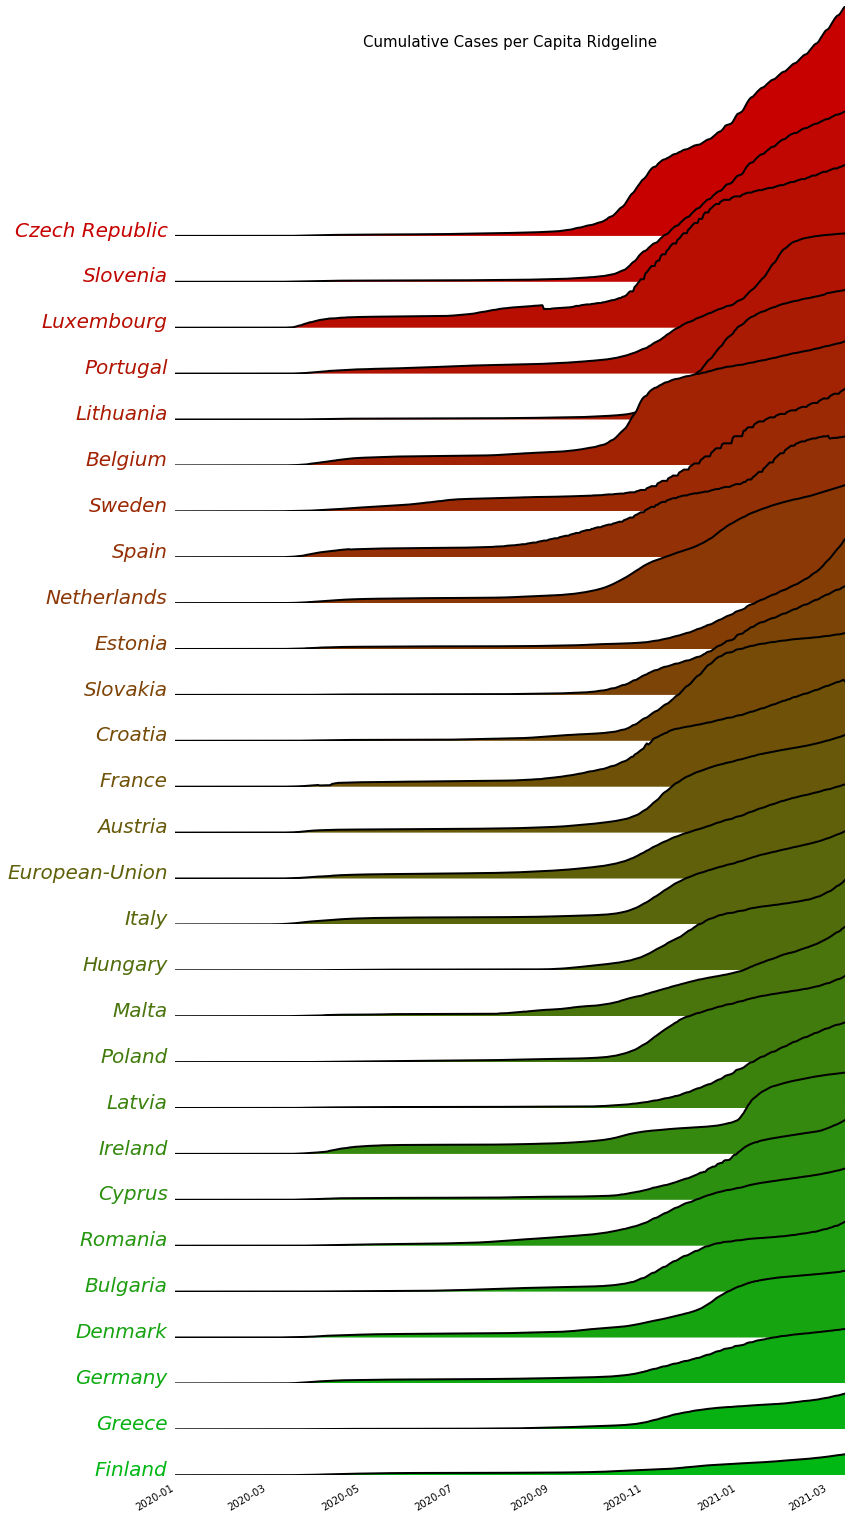

In [32]:
# find max cumulative
maxY=0
countryMax={}
#Find largest number of cases confirmed per 100k as the upper bound of all y axes
for i in range(0,len(dflist)):
    # Add countries and confirmed cases per 100k to dictionary for sorting later
    countryMax[dflist[i]["Country"].iloc[0]]=(dflist[i]["Confirmed per 100k"].max())
    if (dflist[i]["Confirmed per 100k"].max()) > maxY:
        maxY=dflist[i]["Confirmed per 100k"].max()

# Sort countries in order of total covid cases per 100k
countryMaxSorted=sorted(countryMax, key=countryMax.get, reverse=True)
dfSorted=[]

# Read and create combined dataframe sorted by total confirmed case numbers
for i, c in enumerate(countryMaxSorted):
    dfSorted.append(pd.read_json(ProcessedDataFolder + f"/{c.replace(' ', '-')}_processed.json"))
    # Assign datetime to dates - used in plotting
    dfSorted[i]["Date"]=pd.to_datetime(dfSorted[i]["Date"])

# Create color map for plot
numCountries=len(dfSorted)
colors=np.zeros([numCountries,3])
colors[:,0]=np.linspace(200/256, 0, numCountries)
colors[:,1]=np.linspace(0, 185/256, numCountries)
colors[:,2]=np.linspace(0, 19/256, numCountries)

# Create long figure to contain all 28 plots sufficiently
plt.figure(figsize=(12,30));
gs=gridspec.GridSpec(numCountries, 1)
x1=pd.to_datetime(dfSorted[0]["Date"])
# Obtain xlimit value for graphing
tickRange=np.arange(x1.iloc[0], x1.iloc[-1], timedelta(days=45));
xlimits=[x1.iloc[0], x1.iloc[-1]]
zero=np.zeros((1,numCountries))

for i in range(0, len(dfSorted)):
    #Location of title
    if i == 2:
        plt.title("Cumulative Cases per Capita Ridgeline", fontsize=15)
    ax=plt.subplot(gs[i])
    # Remove axis ticks
    ax.xaxis.set_ticks_position('none') 
    # Remove rectangular axes border
    plt.rc('axes', linewidth=0)
    plt.rc('lines', linewidth=2)
    plt.xlim(xlimits)
    plt.ylim([0, maxY])
    # Plot countries
    plt.plot(dfSorted[i]["Date"], dfSorted[i]["Confirmed per 100k"], color='k')
    # Shade areas under curve with color from color map
    plt.fill_between(dfSorted[i]["Date"], dfSorted[i]["Confirmed per 100k"], facecolor=colors[i], alpha=1)
    # Remove labels and remaining ticks
    ax.set_ylabel('')
    ax.set_frame_on(False)    
    ax.set_yticklabels([])
    ax.axes.get_yaxis().set_visible(False)
    ax.patch.set_alpha(0)
    # Add country to side of each plot
    ax.text(x1.iloc[0]-timedelta(days=5),10,dfSorted[i]["Country"].iloc[0], fontsize=20, ha="right", color=colors[i], fontstyle="oblique")

# Overlap plots
gs.update(hspace=-0.8)
fig=plt.gcf()
fig.autofmt_xdate()

Ireland can be seen in green on the above ridgeline plot, with a lower number of total confirmed COVID-19 cases than most countries in Europe per capita. Finland has the lowest number of cases, with Czechia (Czech Republic) currently having the highest number of total confirmed cases in the EU.
## Correlation between New Cases and New Deaths

In [33]:
print(f'Correlation between New Cases and Deaths in Ireland: {dfIE["New Cases"].corr(dfIE["New Deaths"]).round(3)}')
print(f'Correlation between New Cases and Deaths in the EU:  {dfEU["New Cases"].corr(dfEU["New Deaths"]).round(3)}')

Correlation between New Cases and Deaths in Ireland: 0.274
Correlation between New Cases and Deaths in the EU:  0.689


There is a weak positive correlation between the number of new Cases and new Deaths in Ireland of 0.274 at the time of writing. The lag observed between cases and deaths may explain this rather low number. If instead the EU is considered, there is a moderate to strong positive correlation of 0.689 at the time of writing. This is notably higher due to large amounts of averaging in Europe. It may be possible to estimate the lag period between new cases and deaths in Ireland by shifting the column and finding the maximum correlation.

In [34]:
def df_shift(df, col, lag):
    # shift col up and keep others constant
    newdf={}
    for c in df.columns:
        if c==col:
            newdf[c]=df[c].shift(periods=-lag)
        else:
            newdf[c]=df[c]
    return pd.DataFrame(data=newdf)

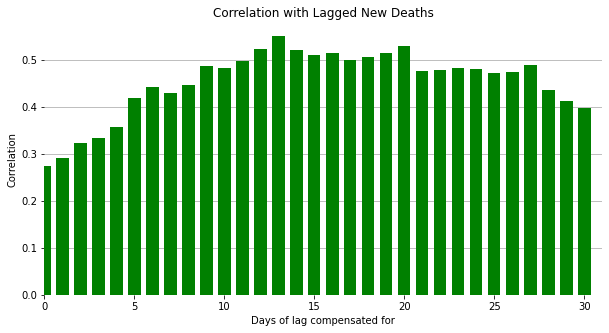

In [35]:
lagRange=31
LCIE={}
for lag in range(0,lagRange):
    newdf=df_shift(dfIE, "New Deaths", lag)
    LCIE[lag]=dfIE["New Cases"].corr(newdf["New Deaths"])

plt.figure(figsize=(10,5));

x = np.arange(0.0, lagRange)
w=0.7
plt.grid(axis="y")
plt.bar(x,LCIE.values(), w, log=False, color='g')
plt.gca().set_axisbelow(True)
plt.xlim([0, lagRange])
plt.title("Correlation with Lagged New Deaths")
plt.ylabel("Correlation")
plt.xlabel("Days of lag compensated for");

The peak correlation occurs where the New Deaths are shifted 13 days earlier, signifying that deaths lag new cases by approximately 13 days, which lines up when compared to the Irish COVID-19 Charts. This is an observation rather than fact, as there are significantly more factors at play which may contribute to COVID-19 deaths, as well as reporting which varies on a daily basis, such as Sweden who only report details 4 out of 7 days.
## Conclusion
Ireland has generally performed better than the average country in the EU over the duration of the Pandemic, however some periods of time have us underperforming quite significantly. Ireland's total confirmed cases continues to climb, but at a slowing rate, whereas in EU this rate is actually increasing at the time of writing.
## Further Work
There is potential for further work with this or similar API's such as the possibility of generating heatmaps which could provide excellent visualisation methods through animations. Determining the correlation between neighbouring countries may also prove rather insightful. Data similar to this as well as those presented in this notebook could provide valuable sources of information about this unusual period of history in the future.